OPTIONS GREEKS VISUALIZER
This demo shows the 5 main Greeks for options:
1. Delta (Δ) - Price sensitivity
2. Gamma (Γ) - Rate of change of Delta
3. Theta (Θ) - Time decay
4. Rho (ρ) - Interest rate sensitivity
5. Vega (ν) - Volatility sensitivity


OPTIONS GREEKS ANALYSIS TABLE
Scenario   Price    Delta    Gamma    Theta    Rho      Vega    
--------------------------------------------------------------------------------
ATM Call   2.49     0.540    0.0692   -0.045   0.042    0.114   
ATM Put    2.08     -0.460   0.0692   -0.031   -0.040   0.114   
ITM Call   10.51    0.961    0.0134   -0.022   0.078    0.027   
ITM Put    9.67     -0.959   0.0171   0.006    -0.079   0.023   
OTM Call   0.64     0.214    0.0534   -0.029   0.016    0.079   
OTM Put    0.56     -0.171   0.0421   -0.023   -0.015   0.076   

Greeks Interpretation:
• Delta: Option price change for $1 stock price change
• Gamma: Delta change for $1 stock price change
• Theta: Option price change per day (time decay)
• Rho: O

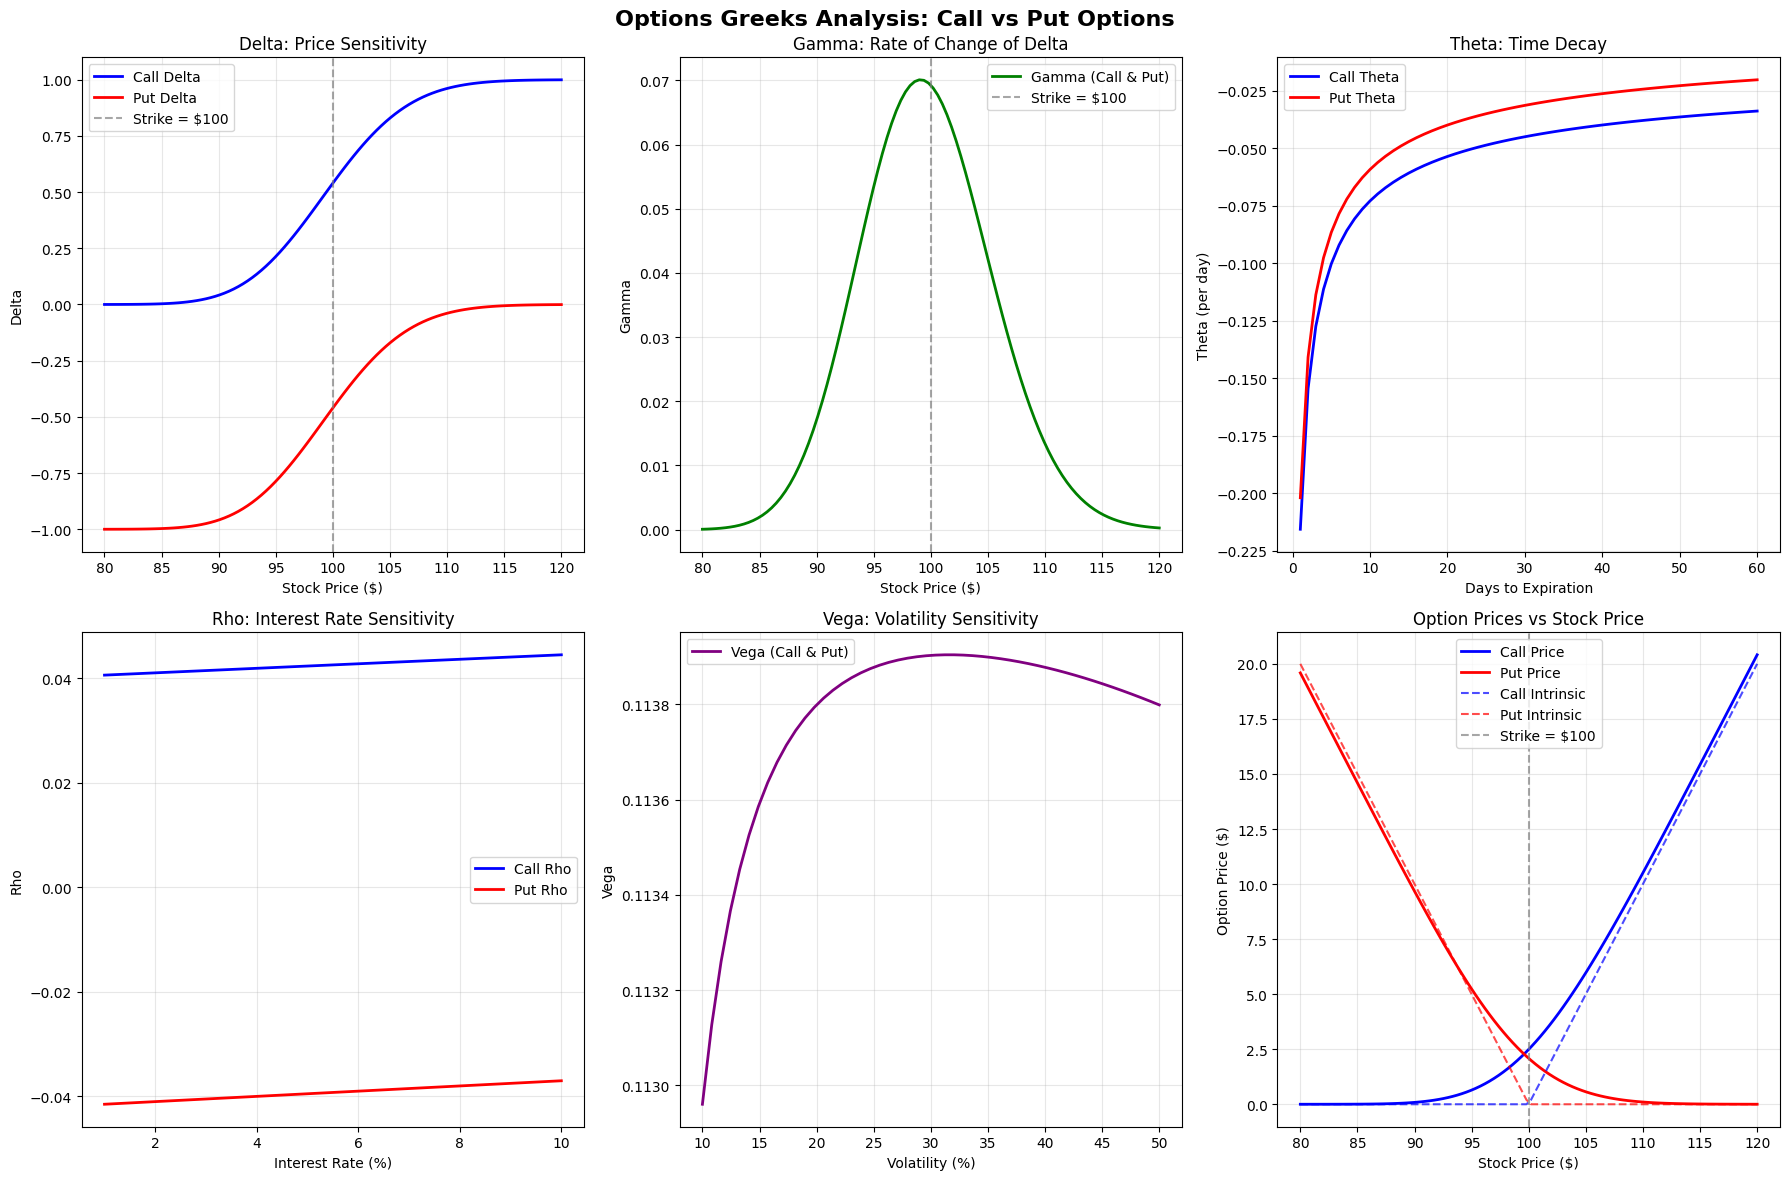


Visualization complete! Check the plots to see how Greeks behave.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from datetime import datetime, timedelta

class OptionsGreeksCalculator:
    def __init__(self, S, K, T, r, sigma):
        """
        Initialize options calculator with Black-Scholes parameters
        S: Current stock price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free rate
        sigma: Volatility
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        
    def d1(self, S=None, T=None, sigma=None):
        """Calculate d1 parameter for Black-Scholes"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        sigma = sigma if sigma is not None else self.sigma
        
        if T <= 0:
            return float('inf') if S > self.K else float('-inf')
        
        return (np.log(S / self.K) + (self.r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S=None, T=None, sigma=None):
        """Calculate d2 parameter for Black-Scholes"""
        T = T if T is not None else self.T
        sigma = sigma if sigma is not None else self.sigma
        return self.d1(S, T, sigma) - sigma * np.sqrt(T)
    
    def call_price(self, S=None, T=None, sigma=None, r=None):
        """Calculate call option price"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        sigma = sigma if sigma is not None else self.sigma
        r = r if r is not None else self.r
        
        if T <= 0:
            return max(S - self.K, 0)
        
        d1_val = self.d1(S, T, sigma)
        d2_val = self.d2(S, T, sigma)
        
        return S * norm.cdf(d1_val) - self.K * np.exp(-r * T) * norm.cdf(d2_val)
    
    def put_price(self, S=None, T=None, sigma=None, r=None):
        """Calculate put option price"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        sigma = sigma if sigma is not None else self.sigma
        r = r if r is not None else self.r
        
        if T <= 0:
            return max(self.K - S, 0)
        
        d1_val = self.d1(S, T, sigma)
        d2_val = self.d2(S, T, sigma)
        
        return self.K * np.exp(-r * T) * norm.cdf(-d2_val) - S * norm.cdf(-d1_val)
    
    def delta(self, option_type='call', S=None, T=None):
        """Calculate Delta - price sensitivity to underlying price"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        
        if T <= 0:
            if option_type == 'call':
                return 1.0 if S > self.K else 0.0
            else:
                return -1.0 if S < self.K else 0.0
        
        d1_val = self.d1(S, T)
        
        if option_type == 'call':
            return norm.cdf(d1_val)
        else:
            return norm.cdf(d1_val) - 1
    
    def gamma(self, S=None, T=None):
        """Calculate Gamma - rate of change of Delta"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        
        if T <= 0:
            return 0.0
        
        d1_val = self.d1(S, T)
        return norm.pdf(d1_val) / (S * self.sigma * np.sqrt(T))
    
    def theta(self, option_type='call', S=None, T=None):
        """Calculate Theta - time decay"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        
        if T <= 0:
            return 0.0
        
        d1_val = self.d1(S, T)
        d2_val = self.d2(S, T)
        
        term1 = -S * norm.pdf(d1_val) * self.sigma / (2 * np.sqrt(T))
        
        if option_type == 'call':
            term2 = -self.r * self.K * np.exp(-self.r * T) * norm.cdf(d2_val)
            return (term1 + term2) / 365  # Per day
        else:
            term2 = self.r * self.K * np.exp(-self.r * T) * norm.cdf(-d2_val)
            return (term1 + term2) / 365  # Per day
    
    def rho(self, option_type='call', S=None, T=None):
        """Calculate Rho - sensitivity to interest rate"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        
        if T <= 0:
            return 0.0
        
        d2_val = self.d2(S, T)
        
        if option_type == 'call':
            return self.K * T * np.exp(-self.r * T) * norm.cdf(d2_val) / 100
        else:
            return -self.K * T * np.exp(-self.r * T) * norm.cdf(-d2_val) / 100
    
    def vega(self, S=None, T=None):
        """Calculate Vega - sensitivity to volatility"""
        S = S if S is not None else self.S
        T = T if T is not None else self.T
        
        if T <= 0:
            return 0.0
        
        d1_val = self.d1(S, T)
        return S * norm.pdf(d1_val) * np.sqrt(T) / 100

def create_greeks_visualization():
    """Create comprehensive Greeks visualization"""
    
    # Set up base parameters (realistic example)
    S0 = 100  # Current stock price
    K = 100   # Strike price (ATM)
    T = 30/365  # 30 days to expiration
    r = 0.05  # 5% risk-free rate
    sigma = 0.20  # 20% volatility
    
    calc = OptionsGreeksCalculator(S0, K, T, r, sigma)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Options Greeks Analysis: Call vs Put Options', fontsize=16, fontweight='bold')
    
    # 1. Delta vs Stock Price
    ax1 = axes[0, 0]
    stock_prices = np.linspace(80, 120, 100)
    call_deltas = [calc.delta('call', S=S) for S in stock_prices]
    put_deltas = [calc.delta('put', S=S) for S in stock_prices]
    
    ax1.plot(stock_prices, call_deltas, 'b-', linewidth=2, label='Call Delta')
    ax1.plot(stock_prices, put_deltas, 'r-', linewidth=2, label='Put Delta')
    ax1.axvline(x=K, color='gray', linestyle='--', alpha=0.7, label=f'Strike = ${K}')
    ax1.set_xlabel('Stock Price ($)')
    ax1.set_ylabel('Delta')
    ax1.set_title('Delta: Price Sensitivity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Gamma vs Stock Price
    ax2 = axes[0, 1]
    gammas = [calc.gamma(S=S) for S in stock_prices]
    
    ax2.plot(stock_prices, gammas, 'g-', linewidth=2, label='Gamma (Call & Put)')
    ax2.axvline(x=K, color='gray', linestyle='--', alpha=0.7, label=f'Strike = ${K}')
    ax2.set_xlabel('Stock Price ($)')
    ax2.set_ylabel('Gamma')
    ax2.set_title('Gamma: Rate of Change of Delta')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Theta vs Time to Expiration
    ax3 = axes[0, 2]
    days_to_exp = np.linspace(1, 60, 60)
    times_to_exp = days_to_exp / 365
    call_thetas = [calc.theta('call', T=T) for T in times_to_exp]
    put_thetas = [calc.theta('put', T=T) for T in times_to_exp]
    
    ax3.plot(days_to_exp, call_thetas, 'b-', linewidth=2, label='Call Theta')
    ax3.plot(days_to_exp, put_thetas, 'r-', linewidth=2, label='Put Theta')
    ax3.set_xlabel('Days to Expiration')
    ax3.set_ylabel('Theta (per day)')
    ax3.set_title('Theta: Time Decay')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Rho vs Interest Rate
    ax4 = axes[1, 0]
    rates = np.linspace(0.01, 0.10, 50)
    call_rhos = [OptionsGreeksCalculator(S0, K, T, r, sigma).rho('call') for r in rates]
    put_rhos = [OptionsGreeksCalculator(S0, K, T, r, sigma).rho('put') for r in rates]
    
    ax4.plot(rates * 100, call_rhos, 'b-', linewidth=2, label='Call Rho')
    ax4.plot(rates * 100, put_rhos, 'r-', linewidth=2, label='Put Rho')
    ax4.set_xlabel('Interest Rate (%)')
    ax4.set_ylabel('Rho')
    ax4.set_title('Rho: Interest Rate Sensitivity')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Vega vs Volatility
    ax5 = axes[1, 1]
    volatilities = np.linspace(0.10, 0.50, 50)
    vegas = [OptionsGreeksCalculator(S0, K, T, r, vol).vega() for vol in volatilities]
    
    ax5.plot(volatilities * 100, vegas, 'purple', linewidth=2, label='Vega (Call & Put)')
    ax5.set_xlabel('Volatility (%)')
    ax5.set_ylabel('Vega')
    ax5.set_title('Vega: Volatility Sensitivity')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Option Prices vs Stock Price
    ax6 = axes[1, 2]
    call_prices = [calc.call_price(S=S) for S in stock_prices]
    put_prices = [calc.put_price(S=S) for S in stock_prices]
    intrinsic_call = [max(S - K, 0) for S in stock_prices]
    intrinsic_put = [max(K - S, 0) for S in stock_prices]
    
    ax6.plot(stock_prices, call_prices, 'b-', linewidth=2, label='Call Price')
    ax6.plot(stock_prices, put_prices, 'r-', linewidth=2, label='Put Price')
    ax6.plot(stock_prices, intrinsic_call, 'b--', alpha=0.7, label='Call Intrinsic')
    ax6.plot(stock_prices, intrinsic_put, 'r--', alpha=0.7, label='Put Intrinsic')
    ax6.axvline(x=K, color='gray', linestyle='--', alpha=0.7, label=f'Strike = ${K}')
    ax6.set_xlabel('Stock Price ($)')
    ax6.set_ylabel('Option Price ($)')
    ax6.set_title('Option Prices vs Stock Price')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_greeks_table():
    """Print a comprehensive Greeks table"""
    
    # Example scenarios
    scenarios = [
        {"name": "ATM Call", "S": 100, "K": 100, "T": 30/365, "type": "call"},
        {"name": "ATM Put", "S": 100, "K": 100, "T": 30/365, "type": "put"},
        {"name": "ITM Call", "S": 110, "K": 100, "T": 30/365, "type": "call"},
        {"name": "ITM Put", "S": 90, "K": 100, "T": 30/365, "type": "put"},
        {"name": "OTM Call", "S": 95, "K": 100, "T": 30/365, "type": "call"},
        {"name": "OTM Put", "S": 105, "K": 100, "T": 30/365, "type": "put"},
    ]
    
    r = 0.05
    sigma = 0.20
    
    print("\n" + "="*80)
    print("OPTIONS GREEKS ANALYSIS TABLE")
    print("="*80)
    print(f"{'Scenario':<10} {'Price':<8} {'Delta':<8} {'Gamma':<8} {'Theta':<8} {'Rho':<8} {'Vega':<8}")
    print("-"*80)
    
    for scenario in scenarios:
        calc = OptionsGreeksCalculator(scenario["S"], scenario["K"], scenario["T"], r, sigma)
        
        if scenario["type"] == "call":
            price = calc.call_price()
            delta = calc.delta("call")
            theta = calc.theta("call")
            rho = calc.rho("call")
        else:
            price = calc.put_price()
            delta = calc.delta("put")
            theta = calc.theta("put")
            rho = calc.rho("put")
        
        gamma = calc.gamma()
        vega = calc.vega()
        
        print(f"{scenario['name']:<10} {price:<8.2f} {delta:<8.3f} {gamma:<8.4f} {theta:<8.3f} {rho:<8.3f} {vega:<8.3f}")
    
    print("\nGreeks Interpretation:")
    print("• Delta: Option price change for $1 stock price change")
    print("• Gamma: Delta change for $1 stock price change")
    print("• Theta: Option price change per day (time decay)")
    print("• Rho: Option price change for 1% interest rate change")
    print("• Vega: Option price change for 1% volatility change")

def main():
    """Main function to run the Greeks demonstration"""
    
    print("OPTIONS GREEKS VISUALIZER")
    print("="*50)
    print("This demo shows the 5 main Greeks for options:")
    print("1. Delta (Δ) - Price sensitivity")
    print("2. Gamma (Γ) - Rate of change of Delta")
    print("3. Theta (Θ) - Time decay")
    print("4. Rho (ρ) - Interest rate sensitivity")
    print("5. Vega (ν) - Volatility sensitivity")
    print()
    
    # Print numerical examples
    print_greeks_table()
    
    # Create and show visualizations
    print("\nGenerating visualizations...")
    fig = create_greeks_visualization()
    
    # Real-world example calculation
    print("\n" + "="*60)
    print("REAL-WORLD EXAMPLE")
    print("="*60)
    print("Stock: $100, Strike: $100, 30 days to expiration")
    print("Risk-free rate: 5%, Volatility: 20%")
    print()
    
    calc = OptionsGreeksCalculator(100, 100, 30/365, 0.05, 0.20)
    
    call_price = calc.call_price()
    put_price = calc.put_price()
    
    print(f"Call Option Price: ${call_price:.2f}")
    print(f"Put Option Price: ${put_price:.2f}")
    print()
    
    print("Greeks for Call Option:")
    print(f"  Delta: {calc.delta('call'):.3f} (for $1 stock move)")
    print(f"  Gamma: {calc.gamma():.4f} (delta change)")
    print(f"  Theta: {calc.theta('call'):.3f} (per day)")
    print(f"  Rho: {calc.rho('call'):.3f} (for 1% rate change)")
    print(f"  Vega: {calc.vega():.3f} (for 1% vol change)")
    print()
    
    print("Greeks for Put Option:")
    print(f"  Delta: {calc.delta('put'):.3f} (for $1 stock move)")
    print(f"  Gamma: {calc.gamma():.4f} (delta change)")
    print(f"  Theta: {calc.theta('put'):.3f} (per day)")
    print(f"  Rho: {calc.rho('put'):.3f} (for 1% rate change)")
    print(f"  Vega: {calc.vega():.3f} (for 1% vol change)")
    
    # Show the plots
    plt.show()
    
    print("\nVisualization complete! Check the plots to see how Greeks behave.")

if __name__ == "__main__":
    main()

[*********************100%***********************]  5 of 5 completed

Data type: <class 'pandas.core.frame.DataFrame'>
Data shape: (755, 25)
Data columns: MultiIndex([( 'Close',  'AAPL'),
            ( 'Close',  'AMZN'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'META'),
            ( 'Close',  'MSFT'),
            (  'High',  'AAPL'),
            (  'High',  'AMZN'),
            (  'High', 'GOOGL'),
            (  'High',  'META'),
            (  'High',  'MSFT'),
            (   'Low',  'AAPL'),
            (   'Low',  'AMZN'),
            (   'Low', 'GOOGL'),
            (   'Low',  'META'),
            (   'Low',  'MSFT'),
            (  'Open',  'AAPL'),
            (  'Open',  'AMZN'),
            (  'Open', 'GOOGL'),
            (  'Open',  'META'),
            (  'Open',  'MSFT'),
            ('Volume',  'AAPL'),
            ('Volume',  'AMZN'),
            ('Volume', 'GOOGL'),
            ('Volume',  'META'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])
Data index: DatetimeIndex(['2020-07-01', '2020-07-0

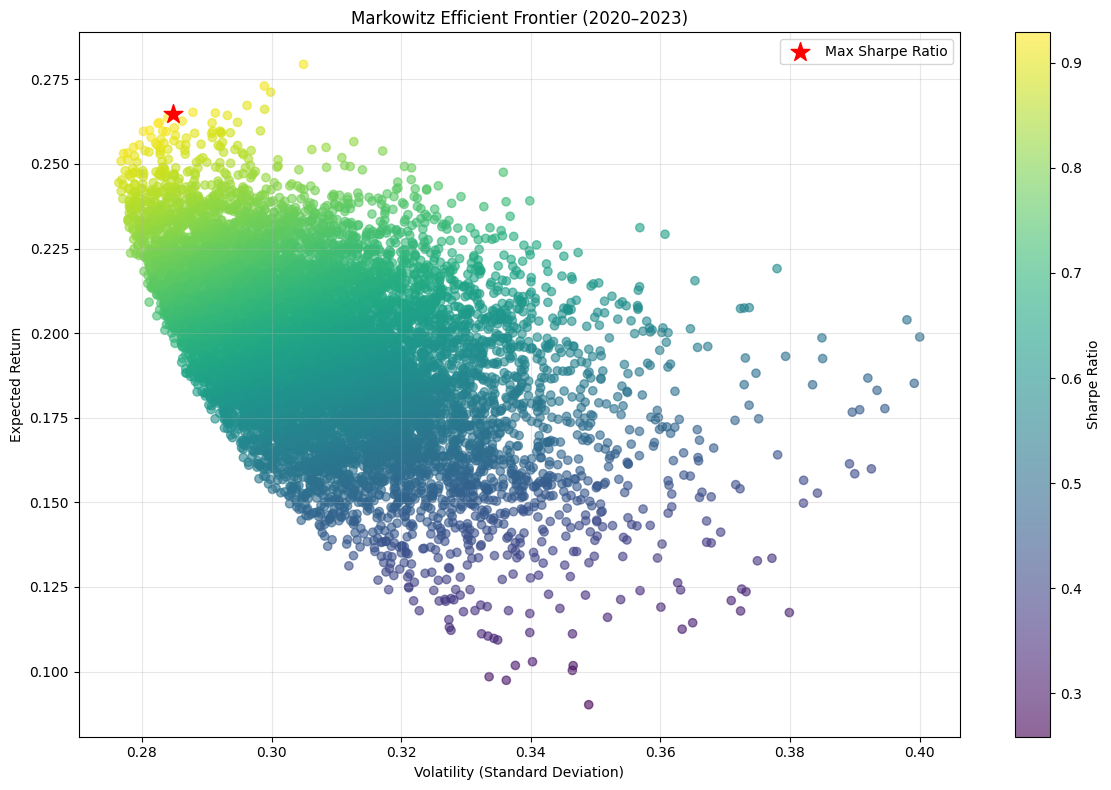

Optimal Portfolio (Max Sharpe Ratio):
Expected Return: 0.2647
Volatility: 0.2849
Sharpe Ratio: 0.9290

Optimal Portfolio Weights:
AAPL: 0.5462 (54.62%)
MSFT: 0.0146 (1.46%)
GOOGL: 0.3616 (36.16%)
AMZN: 0.0230 (2.30%)
META: 0.0545 (5.45%)

Minimum Volatility Portfolio:
Expected Return: 0.2445
Volatility: 0.2764
Sharpe Ratio: 0.8843

Minimum Volatility Portfolio Weights:
AAPL: 0.3182 (31.82%)
MSFT: 0.0221 (2.21%)
GOOGL: 0.2673 (26.73%)
AMZN: 0.0085 (0.85%)
META: 0.3838 (38.38%)

Portfolio Statistics Summary:
Average Return: 0.1948
Average Volatility: 0.3082
Average Sharpe Ratio: 0.6357
Max Sharpe Ratio: 0.9290
Min Volatility: 0.2764


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download historical prices for a few stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
print("Downloading data...")
data = yf.download(tickers, start='2020-07-01', end='2023-07-01')

# Debug: Check the structure of the downloaded data
print("Data type:", type(data))
print("Data shape:", data.shape)
print("Data columns:", data.columns)
print("Data index:", data.index[:5])  # Show first 5 dates

# Check if it's a MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    print("\nMultiIndex detected!")
    print("Level 0 (Price types):", data.columns.get_level_values(0).unique())
    print("Level 1 (Tickers):", data.columns.get_level_values(1).unique())
    
    # Extract adjusted close prices
    if 'Adj Close' in data.columns.get_level_values(0):
        prices = data['Adj Close']
        print("Successfully extracted Adj Close prices")
    else:
        print("Available price types:", data.columns.get_level_values(0).unique())
        # Try alternative column names
        alt_names = ['Close', 'Adj Close', 'Adjusted Close']
        for name in alt_names:
            if name in data.columns.get_level_values(0):
                prices = data[name]
                print(f"Using '{name}' instead of 'Adj Close'")
                break
else:
    print("\nNo MultiIndex - checking regular columns")
    print("Regular columns:", data.columns.tolist())
    
    # If it's a single ticker or different structure
    if 'Adj Close' in data.columns:
        prices = data[['Adj Close']]
        prices.columns = tickers  # Rename to ticker
    else:
        print("Available columns:", data.columns.tolist())
        # Use Close if Adj Close not available
        if 'Close' in data.columns:
            prices = data[['Close']]
            prices.columns = tickers
        else:
            print("Unable to find price data!")
            exit()

# Check if we successfully got prices
if 'prices' in locals():
    print(f"\nPrices shape: {prices.shape}")
    print(f"Prices columns: {prices.columns.tolist()}")
    print(f"First few rows of prices:")
    print(prices.head())
    
    # Check for missing data
    print(f"\nMissing data per ticker:")
    print(prices.isnull().sum())
    
    # Drop any rows with NaN values
    prices_clean = prices.dropna()
    print(f"\nAfter dropping NaN - shape: {prices_clean.shape}")
    
    # Calculate daily returns
    returns = prices_clean.pct_change().dropna()
    print(f"Returns shape: {returns.shape}")
    print(f"Returns head:")
    print(returns.head())
    
    # Annualized mean returns and covariance matrix
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    
    print(f"\nAnnualized mean returns:")
    print(mean_returns)
    print(f"\nCovariance matrix shape: {cov_matrix.shape}")
    
    # Now proceed with the rest of the analysis
    print("\n" + "="*50)
    print("PROCEEDING WITH PORTFOLIO OPTIMIZATION")
    print("="*50)
    
    # Simulate 10,000 portfolios
    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))
    weights_record = []

    np.random.seed(42)  # For reproducibility

    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Handle division by zero for Sharpe ratio
        if portfolio_std > 0:
            sharpe_ratio = portfolio_return / portfolio_std
        else:
            sharpe_ratio = 0
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std
        results[2, i] = sharpe_ratio

    # Convert to DataFrame
    results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe'])
    weights_df = pd.DataFrame(weights_record, columns=tickers)

    # Identify the optimal (max Sharpe) portfolio
    max_sharpe_idx = results_df['Sharpe'].idxmax()
    max_sharpe_port = results_df.loc[max_sharpe_idx]
    max_sharpe_weights = weights_df.loc[max_sharpe_idx]

    # Plot the Efficient Frontier
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(results_df['Volatility'], results_df['Return'], 
                         c=results_df['Sharpe'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], 
               color='red', marker='*', s=200, label='Max Sharpe Ratio')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.title('Markowitz Efficient Frontier (2020–2023)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Display max Sharpe portfolio details
    print("Optimal Portfolio (Max Sharpe Ratio):")
    print(f"Expected Return: {max_sharpe_port['Return']:.4f}")
    print(f"Volatility: {max_sharpe_port['Volatility']:.4f}")
    print(f"Sharpe Ratio: {max_sharpe_port['Sharpe']:.4f}")
    print("\nOptimal Portfolio Weights:")
    for ticker, weight in max_sharpe_weights.items():
        print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")

    # Additional analysis: Find minimum volatility portfolio
    min_vol_idx = results_df['Volatility'].idxmin()
    min_vol_port = results_df.loc[min_vol_idx]
    min_vol_weights = weights_df.loc[min_vol_idx]

    print(f"\nMinimum Volatility Portfolio:")
    print(f"Expected Return: {min_vol_port['Return']:.4f}")
    print(f"Volatility: {min_vol_port['Volatility']:.4f}")
    print(f"Sharpe Ratio: {min_vol_port['Sharpe']:.4f}")
    print("\nMinimum Volatility Portfolio Weights:")
    for ticker, weight in min_vol_weights.items():
        print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")

    # Display summary statistics
    print(f"\nPortfolio Statistics Summary:")
    print(f"Average Return: {results_df['Return'].mean():.4f}")
    print(f"Average Volatility: {results_df['Volatility'].mean():.4f}")
    print(f"Average Sharpe Ratio: {results_df['Sharpe'].mean():.4f}")
    print(f"Max Sharpe Ratio: {results_df['Sharpe'].max():.4f}")
    print(f"Min Volatility: {results_df['Volatility'].min():.4f}")
    
else:
    print("Failed to extract price data. Please check the data structure above.")

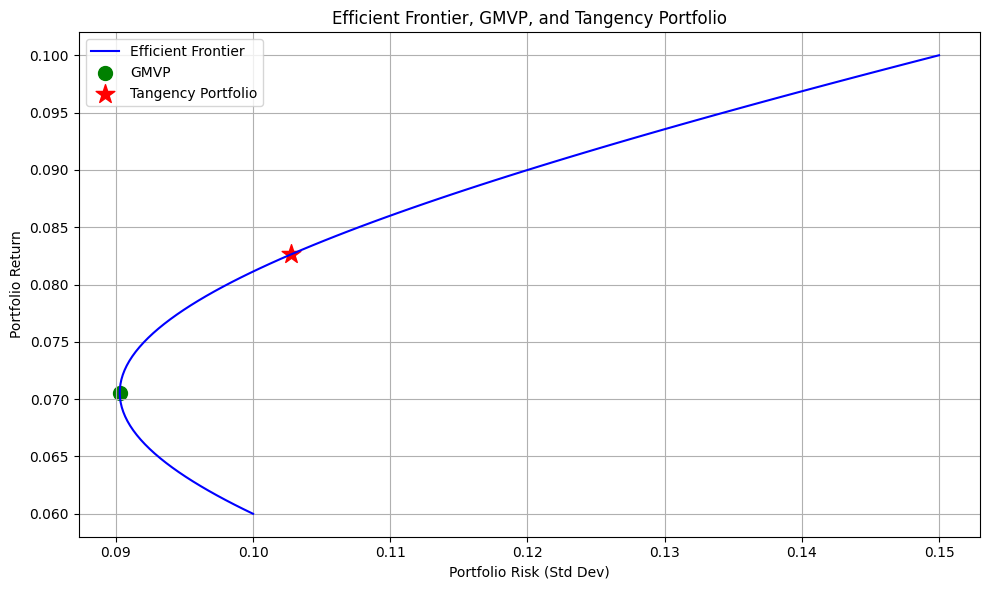

((0.26415094339622647, 0.7358490566037735),
 (np.float64(0.5656565656565657), np.float64(0.43434343434343425)))

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Given example parameters for two assets A and B
mu_A = 0.10       # Expected return of asset A (10%)
mu_B = 0.06       # Expected return of asset B (6%)
sigma_A = 0.15    # Std dev of asset A (15%)
sigma_B = 0.10    # Std dev of asset B (10%)
rho_AB = 0.2      # Correlation between A and B
R_f = 0.03        # Risk-free rate (3%)

# Covariance between A and B
cov_AB = rho_AB * sigma_A * sigma_B

# Generate values of w_A from 0 to 1
w_A = np.linspace(0, 1, 100)
w_B = 1 - w_A

# Portfolio return and variance for each w_A
mu_P = w_A * mu_A + w_B * mu_B
sigma_P = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + 2 * w_A * w_B * cov_AB)
sharpe_P = (mu_P - R_f) / sigma_P

# Global Minimum Variance Portfolio (GMVP) calculation
w_A_gmv = (sigma_B**2 - cov_AB) / (sigma_A**2 + sigma_B**2 - 2 * cov_AB)
w_B_gmv = 1 - w_A_gmv
mu_gmv = w_A_gmv * mu_A + w_B_gmv * mu_B
sigma_gmv = np.sqrt(w_A_gmv**2 * sigma_A**2 + w_B_gmv**2 * sigma_B**2 + 2 * w_A_gmv * w_B_gmv * cov_AB)

# Tangency Portfolio: max Sharpe Ratio
max_sharpe_idx = np.argmax(sharpe_P)
w_A_tan = w_A[max_sharpe_idx]
w_B_tan = 1 - w_A_tan
mu_tan = mu_P[max_sharpe_idx]
sigma_tan = sigma_P[max_sharpe_idx]

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(sigma_P, mu_P, label='Efficient Frontier', color='blue')
plt.scatter(sigma_gmv, mu_gmv, color='green', marker='o', s=100, label='GMVP')
plt.scatter(sigma_tan, mu_tan, color='red', marker='*', s=200, label='Tangency Portfolio')
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier, GMVP, and Tangency Portfolio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(w_A_gmv, w_B_gmv), (w_A_tan, w_B_tan)

In [7]:
import numpy as np

# Expected returns
mu = np.array([0.10, 0.15])  # 10%, 15%
# Covariance matrix
cov = np.array([[0.005, 0.002],
                [0.002, 0.010]])
# Weights in the portfolio
weights = np.array([0.6, 0.4])

# Expected portfolio return
expected_return = np.dot(weights, mu)
# Portfolio variance
portfolio_variance = np.dot(weights.T, np.dot(cov, weights))
portfolio_std = np.sqrt(portfolio_variance)

print(f"Expected Return: {expected_return:.2%}")
print(f"Portfolio Std Dev: {portfolio_std:.2%}")


Expected Return: 12.00%
Portfolio Std Dev: 6.60%


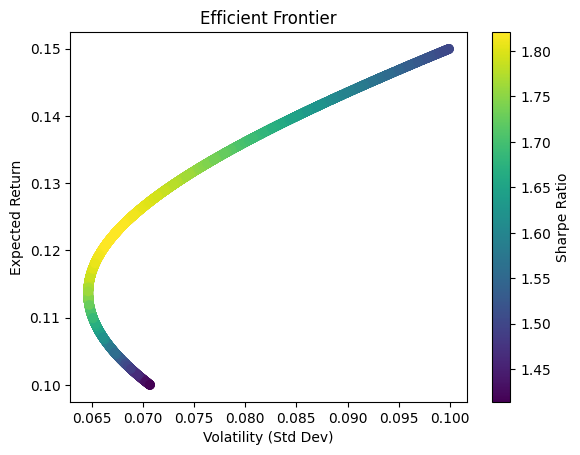

In [8]:
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal

# Simulate 5000 random portfolios
n_assets = 2
n_portfolios = 5000
returns = []
volatilities = []
for _ in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    r = np.dot(w, mu)
    v = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    returns.append(r)
    volatilities.append(v)

plt.scatter(volatilities, returns, c=np.array(returns)/np.array(volatilities), cmap='viridis')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.show()


In [10]:
import statsmodels.api as sm
import yfinance as yf

data = yf.download(["AAPL", "^GSPC"], start="2020-01-01", end="2023-01-01")['Close']
returns = data.pct_change().dropna()
X = sm.add_constant(returns['^GSPC'])
model = sm.OLS(returns['AAPL'], X).fit()

print(model.summary())


[*********************100%***********************]  2 of 2 completed

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1602.
Date:                Tue, 15 Jul 2025   Prob (F-statistic):          1.28e-188
Time:                        20:56:23   Log-Likelihood:                 2199.0
No. Observations:                 755   AIC:                            -4394.
Df Residuals:                     753   BIC:                            -4385.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.271      0.2

C:\Users\mohxm\AppData\Local\Temp\ipykernel_30508\99786573.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, bw_adjust=0.5)  # bw_adjust controls bandwidth


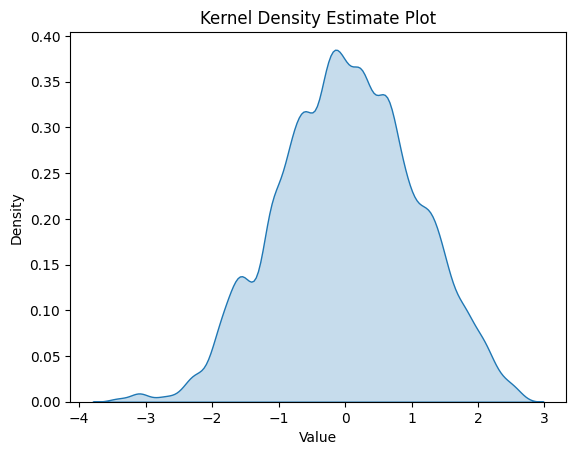

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Data
import numpy as np
data = np.random.normal(loc=0, scale=1, size=1000)

# KDE Plot
sns.kdeplot(data, shade=True, bw_adjust=0.5)  # bw_adjust controls bandwidth
plt.title("Kernel Density Estimate Plot")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


C:\Users\mohxm\AppData\Local\Temp\ipykernel_30508\2665307065.py:31: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
c:\Users\mohxm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


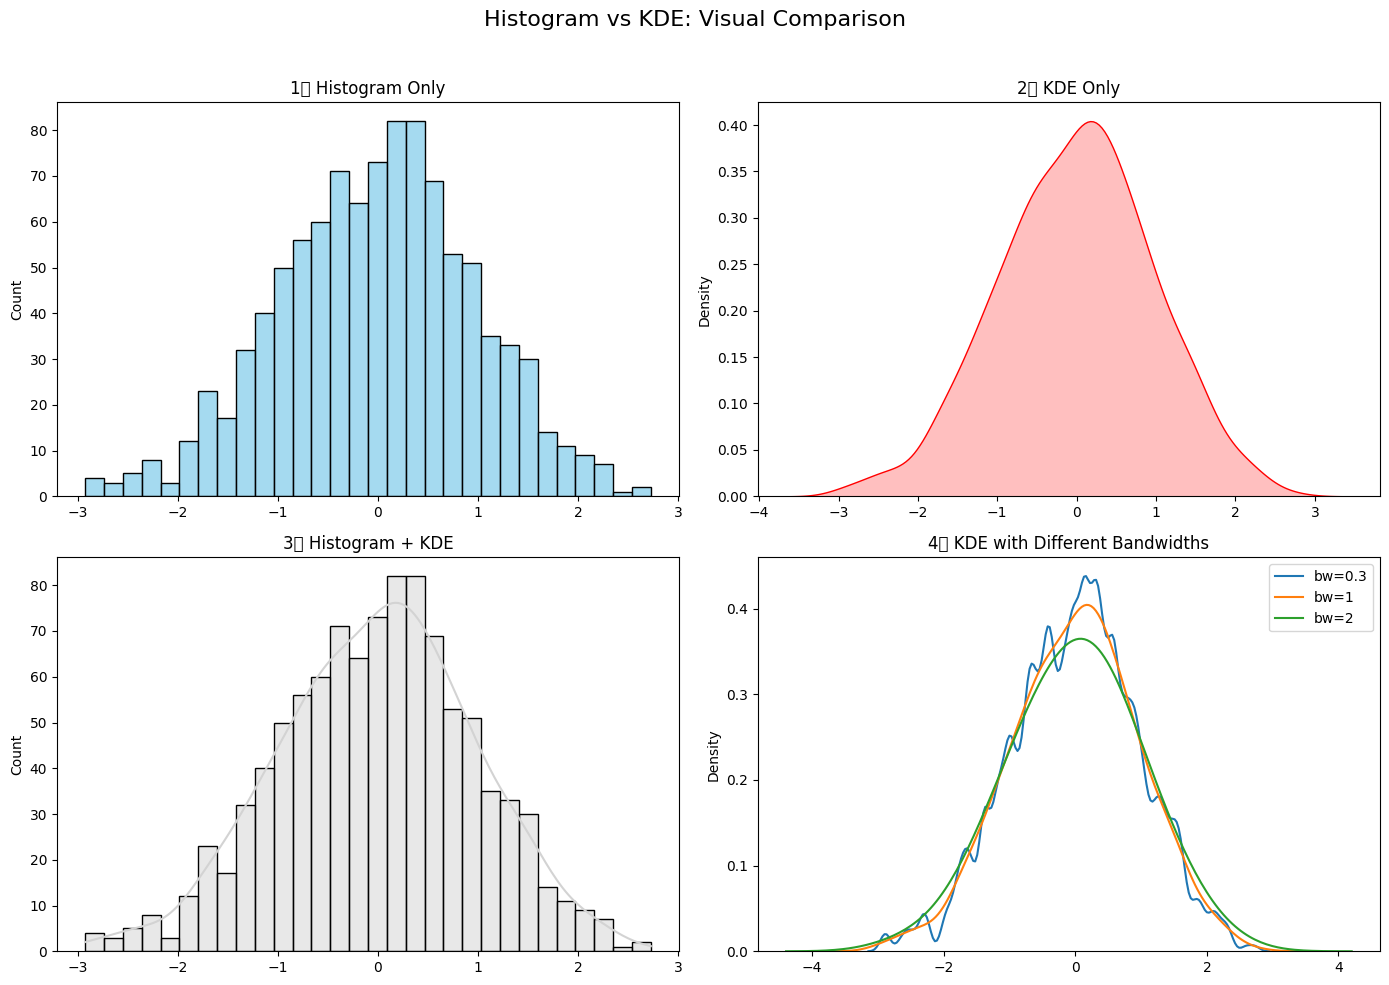

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate normal distribution data
data = np.random.normal(loc=0, scale=1, size=1000)

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Histogram vs KDE: Visual Comparison", fontsize=16)

# 1. Histogram only
sns.histplot(data, bins=30, kde=False, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("1️⃣ Histogram Only")

# 2. KDE only
sns.kdeplot(data, ax=axes[0, 1], color='red', fill=True)
axes[0, 1].set_title("2️⃣ KDE Only")

# 3. Histogram + KDE
sns.histplot(data, bins=30, kde=True, ax=axes[1, 0], color='lightgray')
axes[1, 0].set_title("3️⃣ Histogram + KDE")

# 4. KDE with Different Bandwidths
sns.kdeplot(data, bw_adjust=0.3, label="bw=0.3", ax=axes[1, 1])
sns.kdeplot(data, bw_adjust=1, label="bw=1", ax=axes[1, 1])
sns.kdeplot(data, bw_adjust=2, label="bw=2", ax=axes[1, 1])
axes[1, 1].legend()
axes[1, 1].set_title("4️⃣ KDE with Different Bandwidths")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


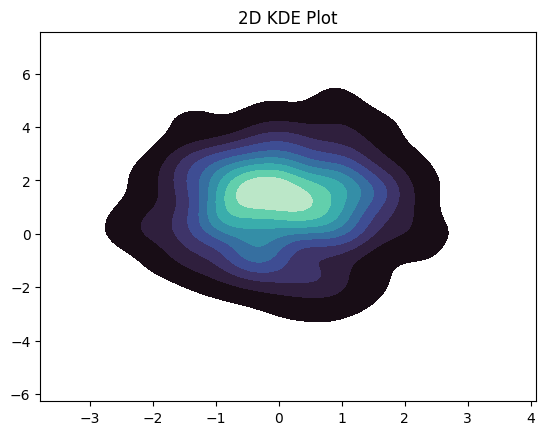

In [3]:
# Bivariate KDE
x = np.random.normal(0, 1, 500)
y = np.random.normal(1, 1.5, 500)

sns.kdeplot(x=x, y=y, fill=True, cmap="mako")
plt.title("2D KDE Plot")
plt.show()


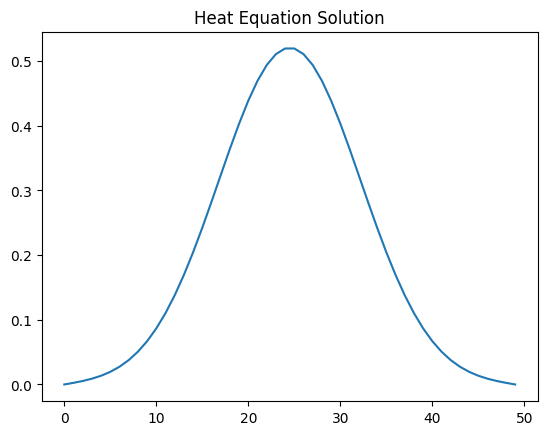

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nx = 50  # spatial steps
nt = 100  # time steps
dx = 1.0 / nx
dt = 0.01
alpha = 0.01  # diffusion coefficient

# Initial condition
u = np.zeros(nx)
u[20:30] = 1  # heat in the middle

# Time evolution
for n in range(nt):
    u[1:-1] = u[1:-1] + alpha * dt / dx**2 * (u[2:] - 2*u[1:-1] + u[:-2])

plt.plot(u)
plt.title("Heat Equation Solution")
plt.show()


In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Download 6 months of Apple (AAPL) stock data
data = yf.download('AAPL', start='2024-01-01', end='2024-06-30')

# Preview
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-01-02  184.290405  187.070052  182.553128  185.789422  82488700
2024-01-03  182.910522  184.528677  182.096477  182.880742  58414500
2024-01-04  180.587524  181.758939  179.565014  180.825770  71983600
2024-01-05  179.862839  181.431354  178.860187  180.666963  62379700
2024-01-08  184.210999  184.250716  180.180517  180.766224  59144500


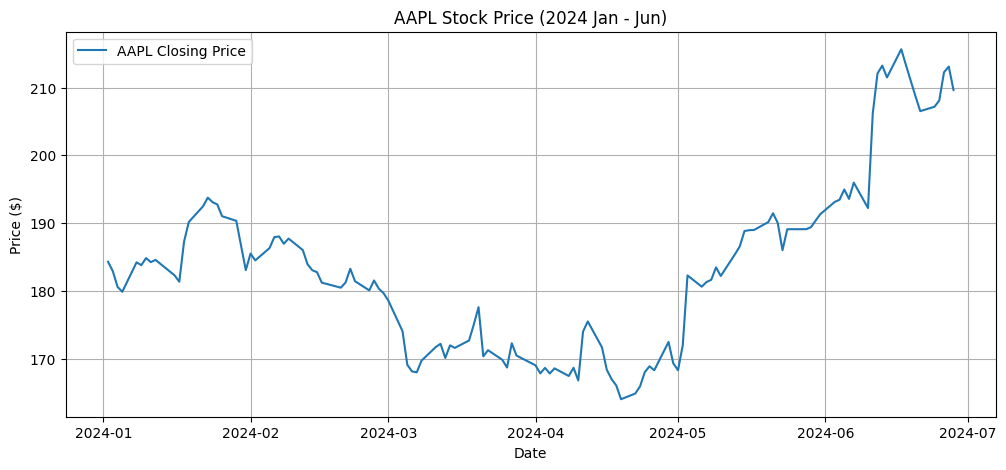

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='AAPL Closing Price')
plt.title("AAPL Stock Price (2024 Jan - Jun)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.update_layout(title='AAPL Candlestick Chart', xaxis_title='Date', yaxis_title='Price ($)')
fig.show()


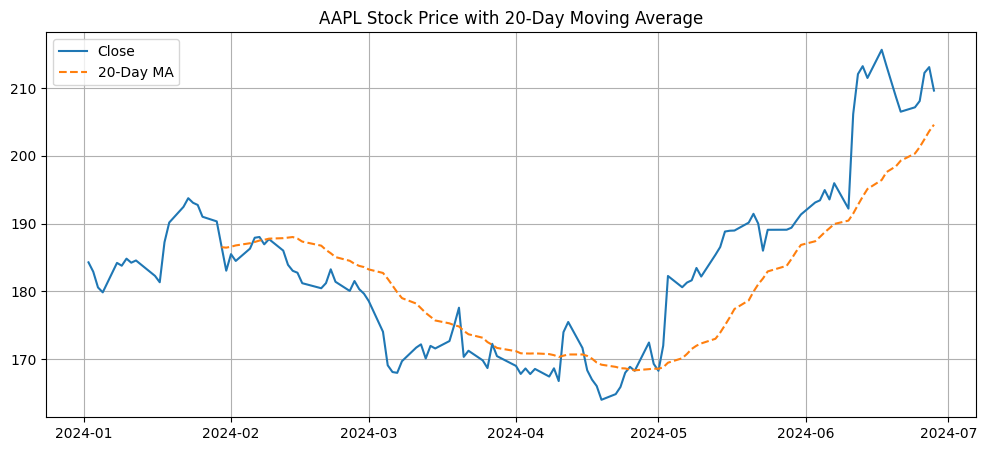

In [11]:
data['MA20'] = data['Close'].rolling(window=20).mean()

plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close')
plt.plot(data['MA20'], label='20-Day MA', linestyle='--')
plt.title("AAPL Stock Price with 20-Day Moving Average")
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  3 of 3 completed


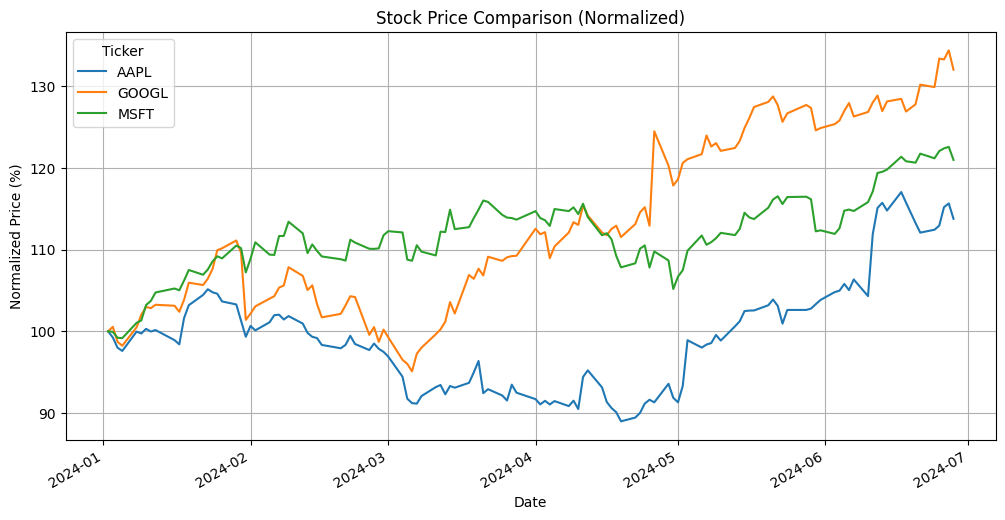

In [12]:
symbols = ['AAPL', 'MSFT', 'GOOGL']
prices = yf.download(symbols, start='2024-01-01', end='2024-06-30')['Close']

# Normalize for comparison
normalized = prices / prices.iloc[0] * 100

normalized.plot(figsize=(12, 6))
plt.title("Stock Price Comparison (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (%)")
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Strategy Alpha over Time'}, xlabel='Date'>

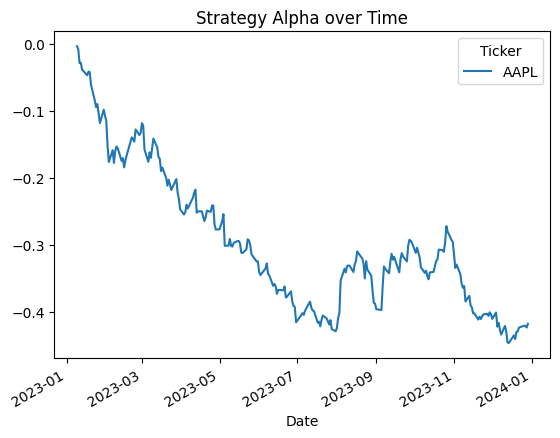

In [13]:
import yfinance as yf
import pandas as pd

# Get stock data
stock = yf.download('AAPL', start='2023-01-01', end='2024-01-01')['Close']
returns = stock.pct_change().dropna()

# Generate momentum signal (3-day rolling return)
signal = returns.rolling(3).mean().shift(1)

# Strategy return = signal * actual return
strategy_returns = signal * returns
benchmark_returns = returns

# Calculate cumulative alpha
alpha = (strategy_returns - benchmark_returns).cumsum()

alpha.plot(title="Strategy Alpha over Time")


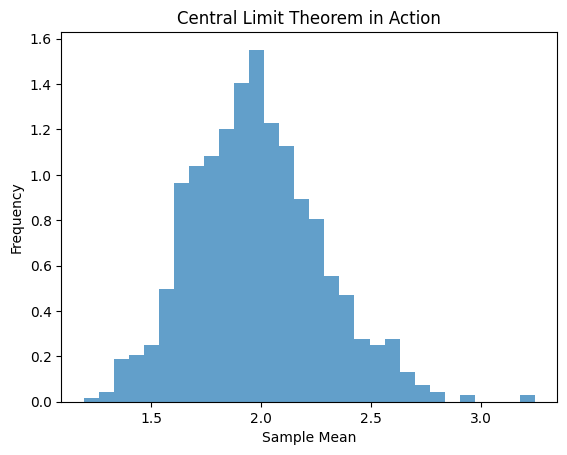

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Population: skewed data
population = np.random.exponential(scale=2, size=100000)

# Draw many samples and compute means
sample_means = []
for _ in range(1000):
    sample = np.random.choice(population, size=50)
    sample_means.append(np.mean(sample))

# Plot histogram of sample means
plt.hist(sample_means, bins=30, density=True, alpha=0.7)
plt.title("Central Limit Theorem in Action")
plt.xlabel("Sample Mean")
plt.ylabel("Frequency")
plt.show()


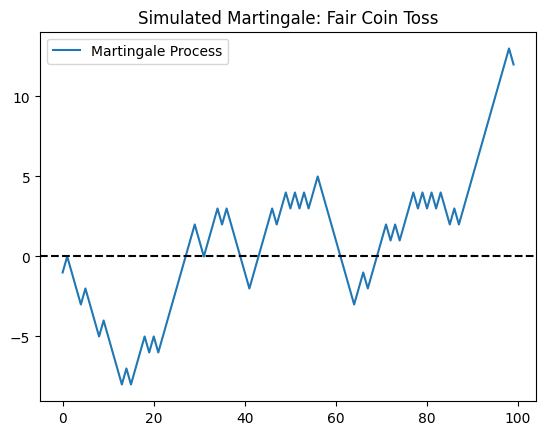

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n = 100
steps = np.random.choice([-1, 1], size=n)  # fair coin toss
martingale = np.cumsum(steps)  # running total

plt.plot(martingale, label="Martingale Process")
plt.axhline(0, color='black', linestyle='--')
plt.title("Simulated Martingale: Fair Coin Toss")
plt.legend()
plt.show()


In [6]:
import yfinance as yf

# Ticker object for DMART on NSE
ticker = yf.Ticker("DMART.NS")

# Download all historical data (date range derived from period1/period2 in your link)
df = ticker.history(period="max")  # 'max' fetches the entire available range

# Save to CSV
df.to_csv("DMART_Historical.csv")
print("Saved to DMART_Historical.csv")


Saved to DMART_Historical.csv
